In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('/kaggle/input/political-sentiment/PS_train.csv')

In [3]:
df_train[:5]

,content,labels
0,தென்காசி தொகுதி புதிய தமிழகம் கட்சி வேட்பாளர் ...,Neutral
1,அண்ணன் இதனை சூசகமாக 11 மாதங்கள் முன்பே பேட்டிய...,Substantiated
2,ஒரு வருடம் ஆகி விட்டது இந்த துயரம் நேர்ந்து......,Opinionated
3,"எடப்பாடியை கண்டுகொள்ளாத ""எடப்பாடி""🫢\n ---\nஆதர...",Positive
4,எங்களின் அரசியல் அடுத்த தலைமுறைக்குமானது \n#மக...,Opinionated


In [4]:
df_val = pd.read_csv('/kaggle/input/political-sentiment/PS_dev.csv')

In [5]:
df_val[:5]

,content,labels
0,ஒற்றே அறை...\n\nபாஜக குளோஸ்!\n\n#மக்களின்_சின்...,Opinionated
1,வாய்ப்பில்லை சார் வாய்ப்பில்லை\n#சீமானின்_சின்...,Substantiated
2,ஒரே போடு இரண்டாக பிளக்கும் | வரலாற்றில் ஒருவன்...,Neutral
3,இப்படியெல்லாம் எடிட் பண்ணிதான் ஓட்டு வாங்கணும்...,Negative
4,#Mike_VoiceOfPeople \n#NTK_Symbol_Mike \n#மக்க...,Substantiated


In [6]:
df_train = df_train.dropna()
df_val = df_val.dropna()

In [7]:
train_label_counts = df_train['labels'].value_counts()
print(train_label_counts)

labels
Opinionated          1361
Sarcastic             790
Neutral               637
Positive              575
Substantiated         412
Negative              406
None of the above     171
Name: count, dtype: int64


In [8]:
val_label_counts = df_val['labels'].value_counts()
print(val_label_counts)

labels
Opinionated          153
Sarcastic            115
Neutral               84
Positive              69
Substantiated         52
Negative              51
None of the above     20
Name: count, dtype: int64


In [9]:
df_merged = pd.concat([df_train, df_val], axis=0)

In [10]:
x_train = df_merged['content']
x_val = df_val['content']

In [11]:
replace_values = {
    "Opinionated" : 0,
    "Sarcastic" : 1,
    "Neutral" : 2,
    "Positive" : 3,
    "Substantiated" : 4,
    "Negative" : 5,
    "None of the above" : 6
}

In [12]:
y_train = df_merged['labels'].replace(replace_values)
y_val = df_val['labels'].replace(replace_values)

<ipython-input-12-3800ea415c6b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = df_merged['labels'].replace(replace_values)
<ipython-input-12-3800ea415c6b>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = df_val['labels'].replace(replace_values)


In [13]:
y_train.value_counts()

labels
0    1514
1     905
2     721
3     644
4     464
5     457
6     191
Name: count, dtype: int64

In [14]:
y_val.value_counts()

labels
0    153
1    115
2     84
3     69
4     52
5     51
6     20
Name: count, dtype: int64

In [15]:
pip install -q indic-nlp-library indic-transliteration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
from indicnlp import common
from indicnlp.tokenize import indic_tokenize
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense

In [17]:
# Set up Indic NLP Resources
common.set_resources_path('/path_to_indic_nlp_resources')

# Define preprocessing function
def preprocess_text(text, language='ta'):
    
    normalizer_factory = IndicNormalizerFactory()
    normalizer = normalizer_factory.get_normalizer(language)
    normalized_text = normalizer.normalize(text)
    
    # Tokenize the text
    tokens = list(indic_tokenize.trivial_tokenize(normalized_text))
    
    # Return the tokenized text as a space-separated string
    return ' '.join(tokens)

In [18]:
# Preprocess the text data
x_train_preprocessed = x_train.apply(preprocess_text)
x_val_preprocessed = x_val.apply(preprocess_text)

# Tokenize the preprocessed text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_preprocessed)

sequences_train = tokenizer.texts_to_sequences(x_train_preprocessed)
sequences_val = tokenizer.texts_to_sequences(x_val_preprocessed)

# Pad sequences
maxlen = max([len(seq) for seq in sequences_train])
x_train = pad_sequences(sequences_train, maxlen=maxlen, padding='pre')
x_val = pad_sequences(sequences_val, maxlen=maxlen, padding='pre')

In [26]:
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 64  # Embedding dimension

# Define the model architecture
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(input_layer)
lstm_layer1 = LSTM(64, return_sequences=True)(embedding_layer)
dropout_layer1 = Dropout(0.5)(lstm_layer1)
lstm_layer2 = LSTM(32, return_sequences=False)(dropout_layer1)
dropout_layer2 = Dropout(0.5)(lstm_layer2)
output_layer = Dense(7, activation='softmax')(dropout_layer2)

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 334)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 334, 64)             │       1,197,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 334, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 334, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,243,559 (4.74 MB)

 Trainable params: 1,243,559 (4.74 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.2785 - loss: 1.8476 - val_accuracy: 0.2941 - val_loss: 1.7096
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.3526 - loss: 1.6721 - val_accuracy: 0.3768 - val_loss: 1.4929
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4448 - loss: 1.4384 - val_accuracy: 0.5938 - val_loss: 1.1348
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5832 - loss: 1.1275 - val_accuracy: 0.7555 - val_loss: 0.7804
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7352 - loss: 0.8342 - val_accuracy: 0.8364 - val_loss: 0.5359
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8202 - loss: 0.5866 - val_accuracy: 0.8934 - val_loss: 0.3753
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8609 - loss: 0.4773 - val_accuracy: 0.8915 - val_loss: 0.3399
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8886 - loss: 0.3913 - val_accu

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

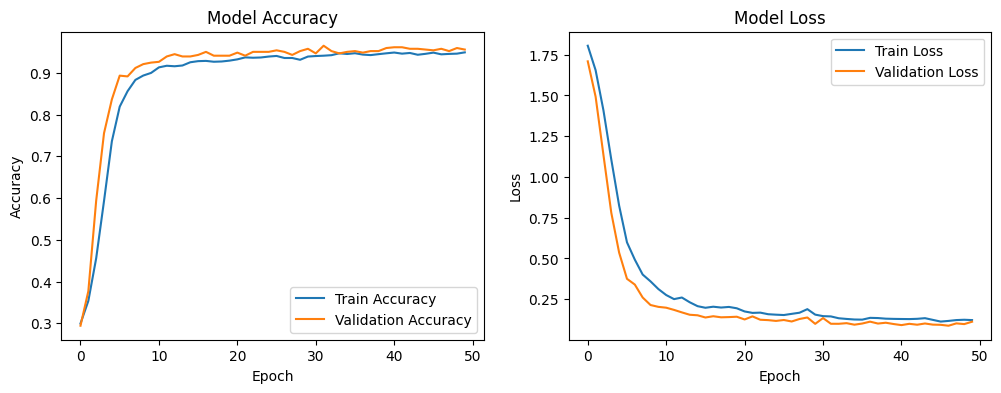

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

# Testing data

In [30]:
df_test = pd.read_csv('/kaggle/input/political-sentiment/PS_test.csv')

In [31]:
df_test[:5]

,Id,content,labels
0,PS_01,இஸ்லாமிய சகோதரர்களுடன் ரமலான் கொண்டாடிய அதிமுக...,Neutral
1,PS_02,\nஓபிஎஸ் - எடப்பாடி போட்டா போட்டி! திடீரென பணி...,Negative
2,PS_03,இன்றைய பரப்புரை:\n\nநாம் தமிழர் கட்சி தலைமை ஒர...,Substantiated
3,PS_04,"🇰🇬🎙️ இன்னும் 05 ஏ நாளில், வெல்வோம் தமிழராய் - ...",Positive
4,PS_05,டாஸ்மாக்ல மட்டும்தான் கருணாநிதி அவர்களின் பெய...,Positive


In [32]:
x_test = df_test['content']
y_test = df_test['labels'].replace(replace_values)

<ipython-input-32-fa0004870769>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = df_test['labels'].replace(replace_values)


In [34]:
x_test_preprocessed = x_test.apply(preprocess_text)
x_test_seq = tokenizer.texts_to_sequences(x_test_preprocessed)
x_test_seq_padded = pad_sequences(x_test_seq, maxlen=maxlen, padding='pre')

In [35]:
pred = model.predict(x_test_seq_padded)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [36]:
y_pred = np.argmax(pred, axis=1)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [38]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred, average='macro') 

# Calculate recall
recall = recall_score(y_test, y_pred, average='macro') 

# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro') 

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# classification report for detailed metrics per class
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(7)]))

Accuracy: 0.2868
Precision: 0.3252
Recall: 0.2803
F1 Score: 0.2964

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.40      0.40       171
           1       0.28      0.33      0.31       106
           2       0.12      0.16      0.14        70
           3       0.27      0.17      0.21        75
           4       0.15      0.18      0.16        51
           5       0.10      0.09      0.09        46
           6       0.94      0.64      0.76        25

    accuracy                           0.29       544
   macro avg       0.33      0.28      0.30       544
weighted avg       0.30      0.29      0.29       544



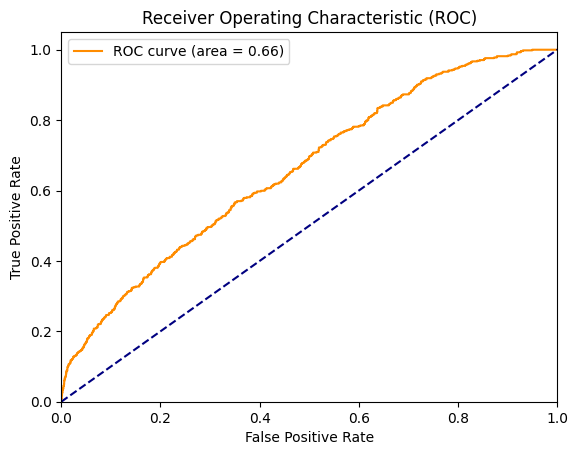

In [39]:
# ROC Curve
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])

fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

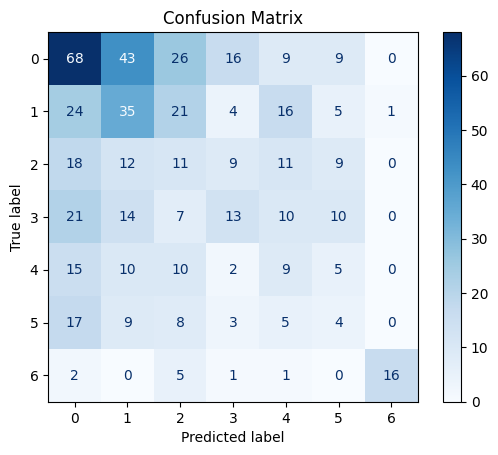

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()